In [1]:
from sqlalchemy import create_engine
import numpy as np
import pandas as pd
import pandas.io.sql as sqlio
import os
from dotenv import load_dotenv
import datetime as dt
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_validate
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import pickle as pkl
import json

In [2]:
RANDOM_STATE = 42

# Read Data

In [3]:
# Curry function to initialize postgres engine and return read_query function

def make_read_query(protocol=None, user=None, password=None, host=None, port=None, db=None):
    load_dotenv()
    
    protocol = protocol if protocol else 'postgresql+psycopg2'
    user = user if user else os.environ.get('POSTGRES_USER')
    password = password if password else os.environ.get('POSTGRES_PASSWORD')
    host = host if host else 'localhost'
    port = port if port else 5432
    db = db if db else os.environ.get('POSTGRES_DB')
    
    db_url = f'{protocol}://{user}:{password}@{host}:{port}/{db}'
    engine = create_engine(db_url)

    def read_query(query, verbose=True):
        if verbose:
            print(query, '\n')
            
        with engine.connect() as conn:
            df = sqlio.read_sql_query(query, conn)

        return df

    return read_query

In [4]:
read_query = make_read_query()

In [5]:
users_enriched = read_query("SELECT * FROM users_enriched")
users_enriched.head()

SELECT * FROM users_enriched 



,id,age,gender,country,city,traffic_source,created_at,first_order_timestamp,last_order_timestamp,days_to_activation,...,avg_days_to_order,std_days_to_order,n_orders,avg_order_items,avg_item_value,avg_order_value,order_items,lifetime_status,segment,predicted_segment
0,56219,60,F,United States,Philadelphia,Facebook,2019-01-02 00:06:00,2021-05-27 23:07:12,2021-05-27 23:07:12,876.0,...,NaN,0.0,1,1.0,74.990,74.990,"{""(70373,\""WranglerÂ® Booty Up Stretch Jean fo...",None,None,None
1,9418,69,F,United Kingdom,Cardiff,Search,2019-01-02 00:36:00,2021-07-30 12:35:12,2023-04-21 14:50:59,940.0,...,630.0,0.0,2,1.0,221.500,221.500,"{""(90353,\""Colleen Skirt Slip\"",Women,Intimate...",None,None,None
2,21731,65,F,China,Harbin,Email,2019-01-02 01:47:00,2023-09-17 22:23:37,2023-09-17 22:23:37,1719.0,...,NaN,0.0,1,4.0,60.985,243.940,"{""(27173,\""Modadorn New Arrivals Spring & fall...",None,None,None
3,39594,17,M,China,Shenzhen,Search,2019-01-02 03:00:00,2019-02-11 03:06:43,2019-10-25 02:29:03,40.0,...,255.0,0.0,2,1.0,35.975,35.975,"{""(49470,\""Billabong Men's Semi-Button Up Stri...",None,None,None
4,2000,30,F,China,Hefei,Search,2019-01-02 03:19:00,NaT,NaT,NaN,...,NaN,NaN,0,NaN,NaN,NaN,None,None,None,None


# EDA

In [6]:
users_enriched.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84011 entries, 0 to 84010
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   id                     84011 non-null  int64         
 1   age                    84011 non-null  int64         
 2   gender                 84011 non-null  object        
 3   country                84011 non-null  object        
 4   city                   84011 non-null  object        
 5   traffic_source         84011 non-null  object        
 6   created_at             84011 non-null  datetime64[ns]
 7   first_order_timestamp  58293 non-null  datetime64[ns]
 8   last_order_timestamp   58293 non-null  datetime64[ns]
 9   days_to_activation     58293 non-null  float64       
 10  active_days            58293 non-null  float64       
 11  inactive_days          58293 non-null  float64       
 12  avg_days_to_order      21899 non-null  float64       
 13  s

In [7]:
users_enriched['inactive_days'] = (users_enriched.last_order_timestamp.max() - users_enriched.last_order_timestamp).dt.days

In [8]:
users_enriched.describe()

,id,age,created_at,first_order_timestamp,last_order_timestamp,days_to_activation,active_days,inactive_days,avg_days_to_order,std_days_to_order,n_orders,avg_order_items,avg_item_value,avg_order_value
count,84011.000000,84011.000000,84011,58293,58293,58293.000000,58293.000000,58293.000000,21899.000000,58293.000000,84011.000000,58293.000000,58293.000000,58293.000000
mean,50064.425611,41.062706,2021-06-14 10:42:19.902129920,2022-08-02 13:44:07.089472768,2023-01-06 23:26:35.611470848,430.072530,157.218071,379.122073,286.218363,25.736982,1.119937,1.448619,59.397607,86.045600
min,1.000000,12.000000,2019-01-02 00:06:00,2019-01-06 02:25:41,2019-01-06 02:25:41,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.020000
25%,25108.500000,26.000000,2020-02-20 04:11:00,2021-10-12 13:24:51,2022-07-01 13:01:12,103.000000,0.000000,80.000000,84.333333,0.000000,0.000000,1.000000,29.945000,34.990000
50%,50099.000000,41.000000,2021-05-23 03:56:00,2022-11-11 09:55:21,2023-05-16 14:03:19,310.000000,0.000000,249.000000,205.000000,0.000000,1.000000,1.000000,46.470000,62.000000
75%,75017.500000,56.000000,2022-09-24 04:51:30,2023-08-09 14:54:31,2023-11-02 00:05:26,659.000000,172.000000,568.000000,403.000000,0.000000,2.000000,2.000000,70.983333,109.350000
max,100000.000000,70.000000,2024-01-16 19:46:14.316147,2024-01-21 10:09:51.990337,2024-01-21 12:55:19.720387,1828.000000,1759.000000,1841.000000,1744.000000,1221.880518,25.000000,4.000000,999.000000,1341.490000
std,28864.127943,17.034090,NaN,NaN,NaN,399.416052,305.310117,377.716575,274.835583,90.568065,1.150198,0.712334,53.434791,83.088805


In [9]:
inactive_users = users_enriched.loc[users_enriched.n_orders==0].copy()
one_off_customers = users_enriched.loc[users_enriched.n_orders==1].copy()
repeat_purchasers = users_enriched.loc[users_enriched.n_orders>1].copy()

print('Repeat Purchasers:', repeat_purchasers.shape[0], 
      'One-Off Customers', one_off_customers.shape[0], 
      'Inactive Users', inactive_users.shape[0])

Repeat Purchasers: 21899 One-Off Customers 36394 Inactive Users 25718


In [10]:
def plot_histograms(df, columns=None, width=14, height=7, bins=20):
    columns = df.columns if columns is None else columns
    n_subplots = len(columns)
    n_subplot_rows = round(np.sqrt(n_subplots))
    n_subplot_cols = n_subplots / n_subplot_rows

    n_subplot_cols = int(n_subplot_cols) + 1 if n_subplot_cols % 1 > 0 else int(n_subplot_cols)
    
    fig, axs = plt.subplots(n_subplot_rows, n_subplot_cols)
    fig.set_figwidth(14)
    fig.set_figheight(7)
    plt.tight_layout()

    for i, col in enumerate(columns):
        ax_row = i // n_subplot_cols
        ax_col = i % n_subplot_cols
        ax = axs[ax_row,ax_col]
        ax.set_title(col)
        df[col].hist(bins=bins, ax=ax)

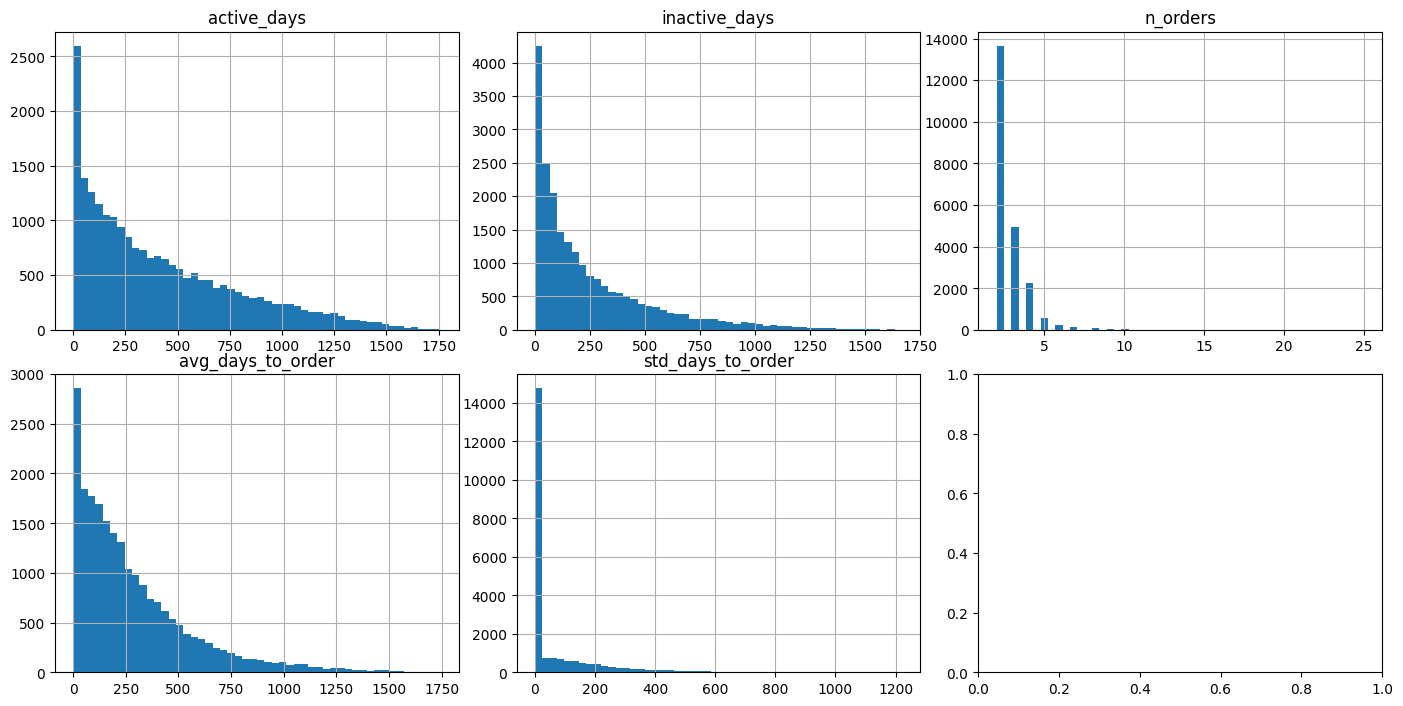

In [11]:
hist_cols = ['active_days', 'inactive_days', 'n_orders', 'avg_days_to_order', 'std_days_to_order']
plot_histograms(repeat_purchasers[hist_cols], bins=50)

In [12]:
repeat_purchasers[hist_cols].describe()

,active_days,inactive_days,n_orders,avg_days_to_order,std_days_to_order
count,21899.000000,21899.000000,21899.000000,21899.000000,21899.000000
mean,418.499155,250.309375,2.634504,286.218363,68.509333
std,372.536505,274.140398,1.133329,274.835583,137.494130
min,0.000000,0.000000,2.000000,0.000000,0.000000
25%,112.000000,48.000000,2.000000,84.333333,0.000000
50%,312.000000,150.000000,2.000000,205.000000,0.000000
75%,642.000000,363.000000,3.000000,403.000000,79.830028
max,1759.000000,1667.000000,25.000000,1744.000000,1221.880518


## Days to Order

<Axes: xlabel='active_days', ylabel='inactive_days'>

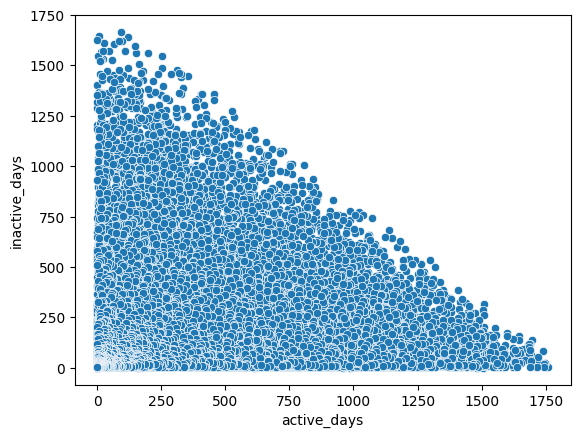

In [13]:
sns.scatterplot(repeat_purchasers, x='active_days', y='inactive_days')

<Axes: xlabel='active_days', ylabel='n_orders'>

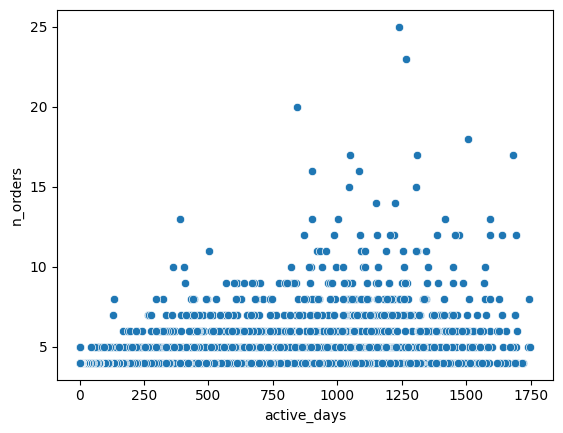

In [14]:
sns.scatterplot(repeat_purchasers[repeat_purchasers.n_orders>3], x='active_days', y='n_orders')

<Axes: xlabel='active_days', ylabel='avg_days_to_order'>

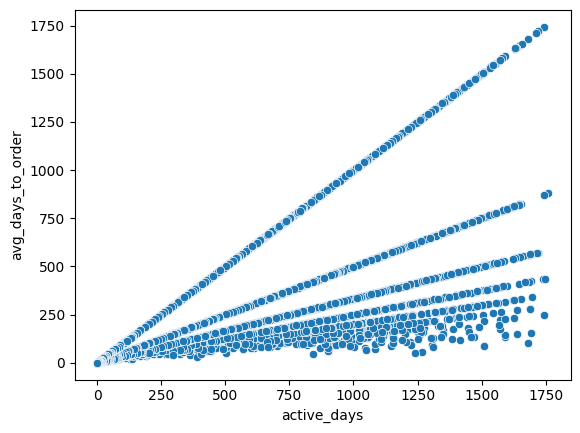

In [15]:
sns.scatterplot(repeat_purchasers, x='active_days', y='avg_days_to_order')

<Axes: xlabel='active_days', ylabel='std_days_to_order'>

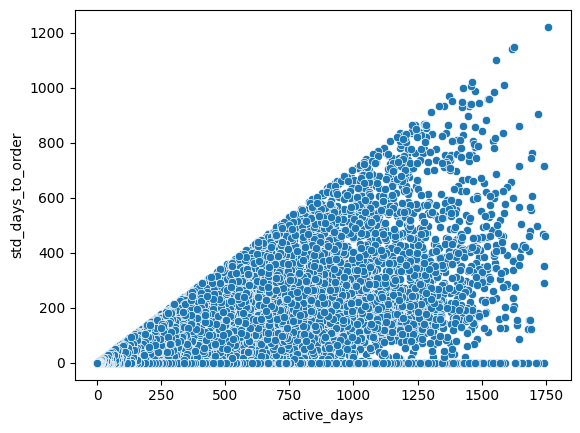

In [16]:
sns.scatterplot(repeat_purchasers, x='active_days', y='std_days_to_order')

<Axes: xlabel='n_orders', ylabel='avg_days_to_order'>

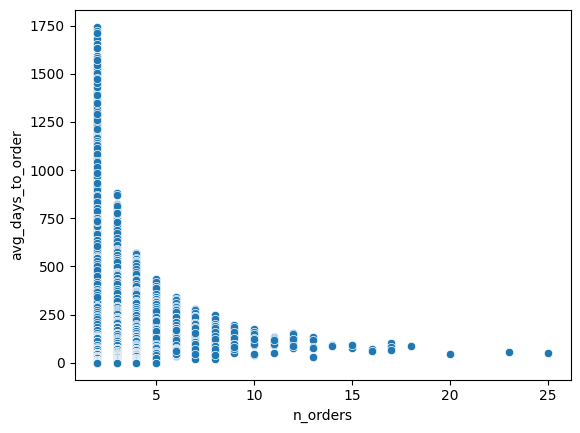

In [17]:
sns.scatterplot(repeat_purchasers, x='n_orders', y='avg_days_to_order')

<Axes: xlabel='n_orders', ylabel='std_days_to_order'>

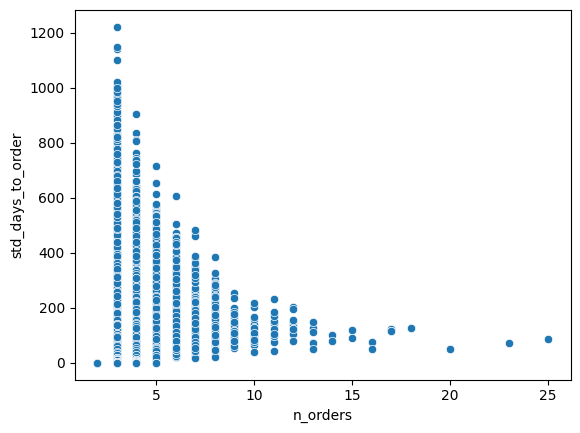

In [18]:
sns.scatterplot(repeat_purchasers, x='n_orders', y='std_days_to_order')

<Axes: xlabel='avg_days_to_order', ylabel='std_days_to_order'>

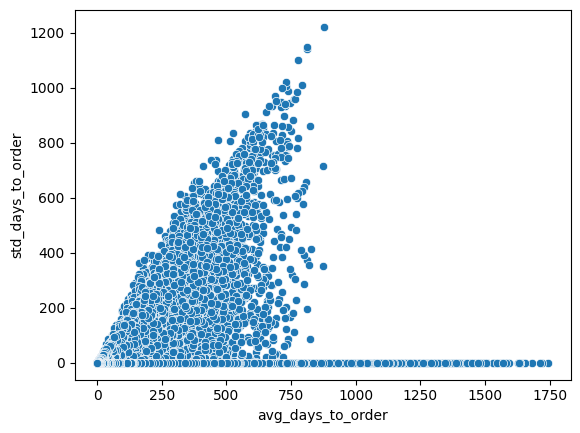

In [19]:
sns.scatterplot(repeat_purchasers, x='avg_days_to_order', y='std_days_to_order')

**Observations:**
- Average and standard deviation for days to order have high upwards deviation. They both converge around a smaller mean with increasing number of orders.
- Inactive days also converges around a smaller mean with increasing number of orders.

In [20]:
repeat_purchasers_3 = repeat_purchasers.loc[repeat_purchasers.n_orders>=3]
repeat_purchasers_10 = repeat_purchasers.loc[repeat_purchasers.n_orders>=5]
repeat_purchasers_rows = repeat_purchasers.shape[0]
repeat_purchasers_rows_3 = repeat_purchasers_3.shape[0]
repeat_purchasers_rows_10 = repeat_purchasers_10.shape[0]

print('#Repeat Purchasers:', repeat_purchasers_rows, 
      '| #Repeat Purchasers (Purchesed>3):', repeat_purchasers_rows_3, 
      '| #Repeat Purchasers (Purchsed>10):', repeat_purchasers_rows_10)
print('% Repeat Purchasers (Purchsed>3):', str(round(repeat_purchasers_rows_3/repeat_purchasers_rows*100, 2))+'%',
      '| % Repeat Purchasers (Purchsed>10):', str(round(repeat_purchasers_rows_10/repeat_purchasers_rows*100, 2))+'%',)

#Repeat Purchasers: 21899 | #Repeat Purchasers (Purchesed>3): 8245 | #Repeat Purchasers (Purchsed>10): 1068
% Repeat Purchasers (Purchsed>3): 37.65% | % Repeat Purchasers (Purchsed>10): 4.88%


### Purchased >= 3

<Axes: >

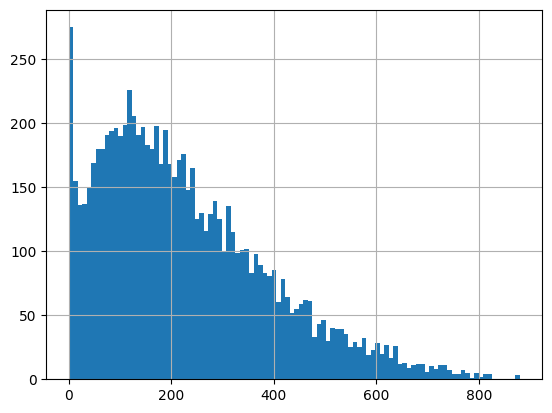

In [21]:
repeat_purchasers_3.avg_days_to_order.hist(bins=100)

<Axes: >

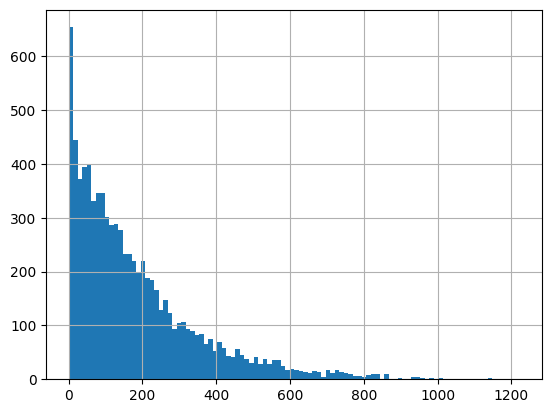

In [22]:
repeat_purchasers_3.std_days_to_order.hist(bins=100)

<Axes: xlabel='avg_days_to_order', ylabel='std_days_to_order'>

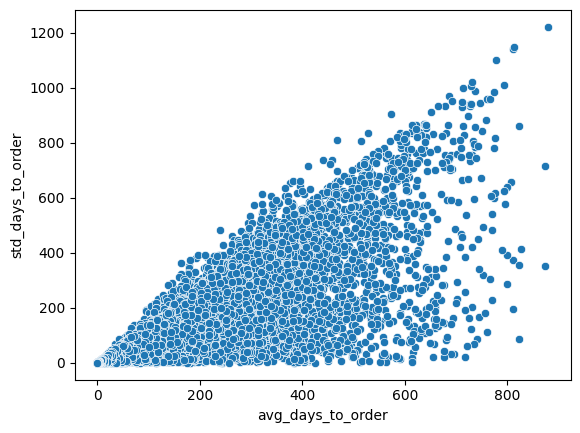

In [23]:
sns.scatterplot(repeat_purchasers_3, x='avg_days_to_order', y='std_days_to_order')

<Axes: >

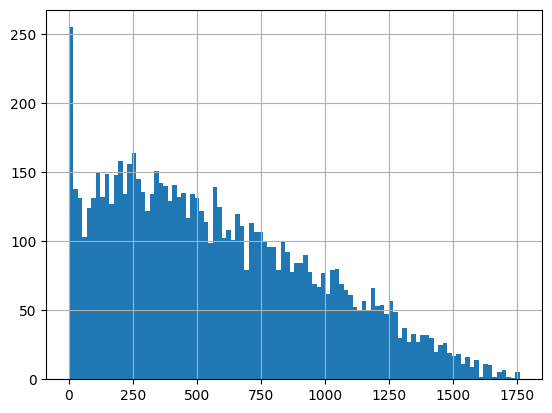

In [24]:
repeat_purchasers_3.active_days.hist(bins=100)

<Axes: xlabel='active_days', ylabel='avg_days_to_order'>

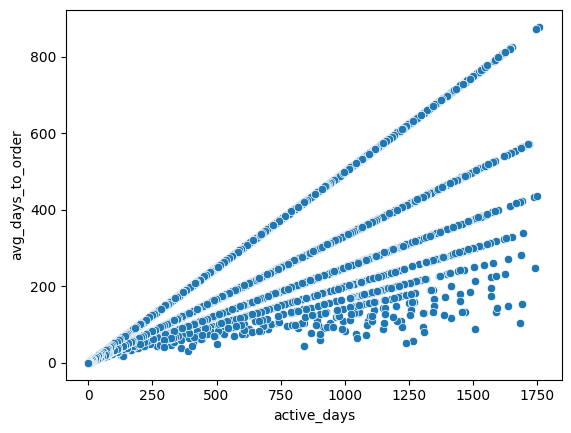

In [25]:
sns.scatterplot(repeat_purchasers_3, x='active_days', y='avg_days_to_order')

<Axes: xlabel='active_days', ylabel='std_days_to_order'>

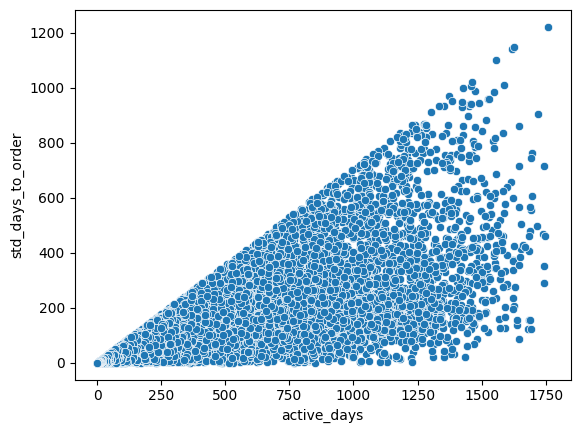

In [26]:
sns.scatterplot(repeat_purchasers_3, x='active_days', y='std_days_to_order')

### Purchased >= 10

In [27]:
repeat_purchasers_10[['avg_days_to_order', 'std_days_to_order']].describe()

,avg_days_to_order,std_days_to_order
count,1068.000000,1068.000000
mean,176.909273,177.330492
std,83.556378,110.362308
min,0.250000,0.500000
25%,114.312500,96.596212
50%,168.625000,152.997328
75%,229.425000,230.432782
max,437.000000,714.993007


<Axes: >

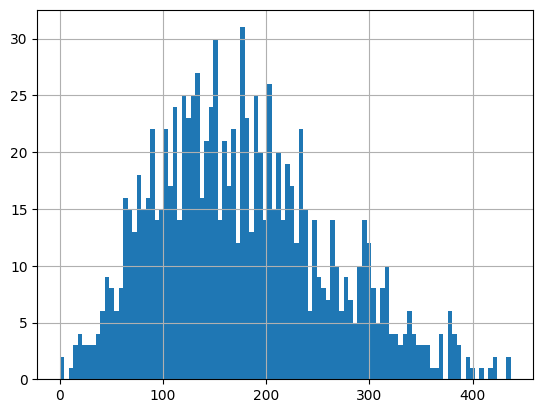

In [28]:
repeat_purchasers_10.avg_days_to_order.hist(bins=100)

<Axes: >

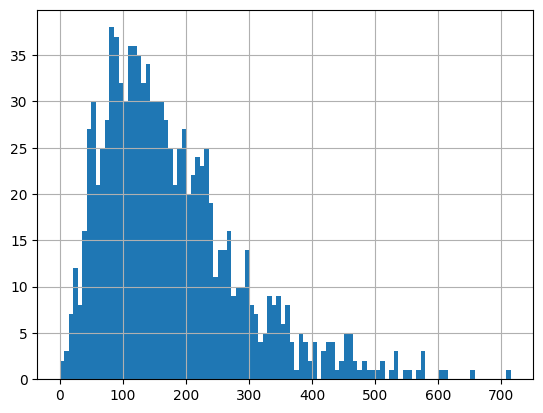

In [29]:
repeat_purchasers_10.std_days_to_order.hist(bins=100)

<Axes: xlabel='avg_days_to_order', ylabel='std_days_to_order'>

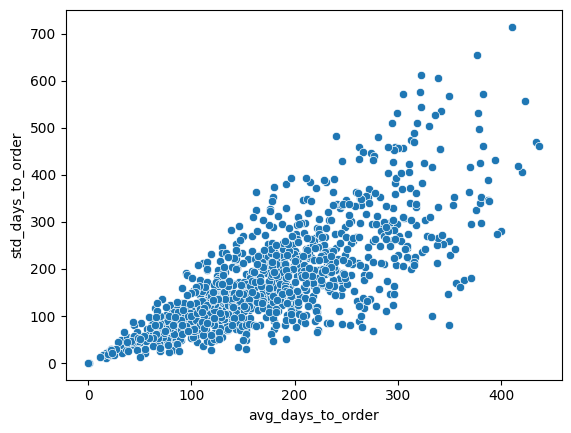

In [30]:
sns.scatterplot(repeat_purchasers_10, x='avg_days_to_order', y='std_days_to_order')

<Axes: xlabel='active_days', ylabel='avg_days_to_order'>

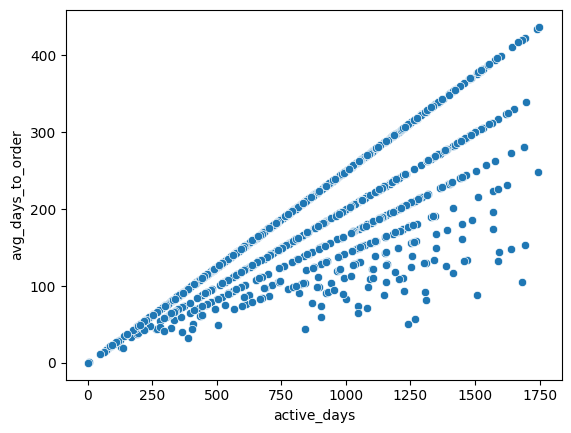

In [31]:
sns.scatterplot(repeat_purchasers_10, x='active_days', y='avg_days_to_order')

<Axes: xlabel='active_days', ylabel='std_days_to_order'>

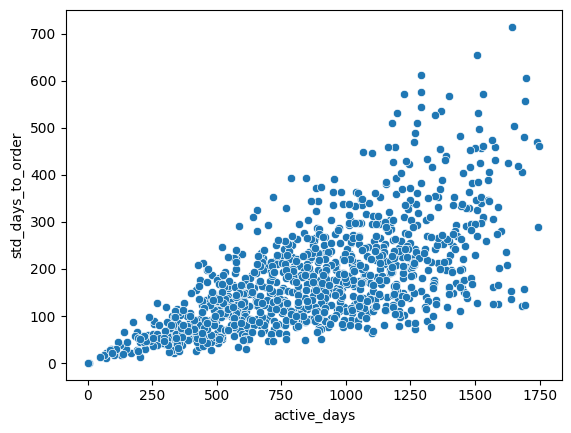

In [32]:
sns.scatterplot(repeat_purchasers_10, x='active_days', y='std_days_to_order')

# Heuristic-based Churn Flags

In [33]:
user_dto_anomalie_lims = repeat_purchasers.avg_days_to_order + 2 * repeat_purchasers.std_days_to_order
print('User Days to Order Anomalie Limits:')
print('\nHead:\n', user_dto_anomalie_lims.value_counts().head(10))
print('\nTail:\n', user_dto_anomalie_lims.value_counts().tail(10))

User Days to Order Anomalie Limits:

Head:
 0.0    350
1.0    153
2.0     92
3.0     90
5.0     75
8.0     72
6.0     65
7.0     63
4.0     63
9.0     60
Name: count, dtype: int64

Tail:
 1553.491124    1
1408.839321    1
2636.303533    1
757.259018     1
5.952135       1
6.828427       1
5.829999       1
11.485281      1
6.742641       1
23.970563      1
Name: count, dtype: int64


In [34]:
avg_dto_anomalie_lim = repeat_purchasers_10.avg_days_to_order.mean() + 2 * repeat_purchasers_10.avg_days_to_order.std()
print('Average Days to Order Anomalie Limit:', avg_dto_anomalie_lim)

Average Days to Order Anomalie Limit: 344.0220278603793


In [35]:
repeat_purchasers['lifetime_status'] = 'Active'
churn_mask = (repeat_purchasers.inactive_days > user_dto_anomalie_lims) | (repeat_purchasers.inactive_days > 365) 
repeat_purchasers.loc[churn_mask, 'lifetime_status'] = 'Churned'

In [36]:
repeat_purchasers.lifetime_status.value_counts()

lifetime_status
Active     12451
Churned     9448
Name: count, dtype: int64

<Axes: xlabel='avg_days_to_order', ylabel='inactive_days'>

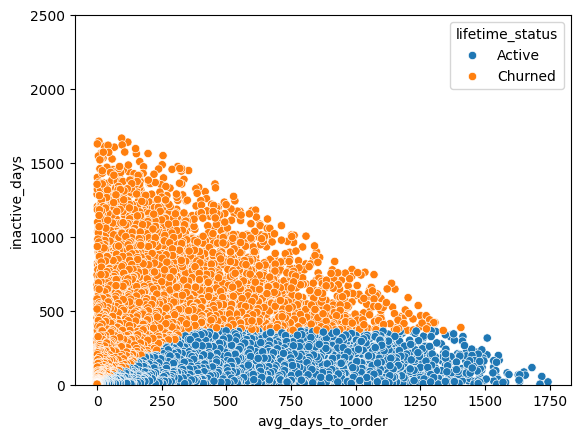

In [37]:
plt.ylim(0, 2500)
sns.scatterplot(repeat_purchasers, x='avg_days_to_order', y='inactive_days', hue='lifetime_status')

<Axes: xlabel='avg_days_to_order', ylabel='inactive_days'>

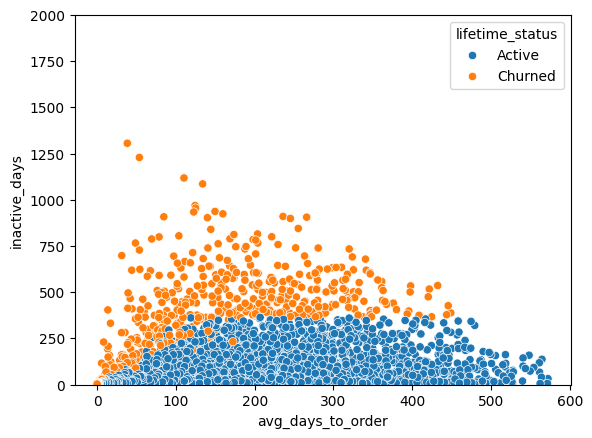

In [38]:
plt.ylim(0, 2000)
sns.scatterplot(repeat_purchasers[repeat_purchasers.n_orders>3], x='avg_days_to_order', y='inactive_days', hue='lifetime_status')

<Axes: xlabel='avg_days_to_order', ylabel='inactive_days'>

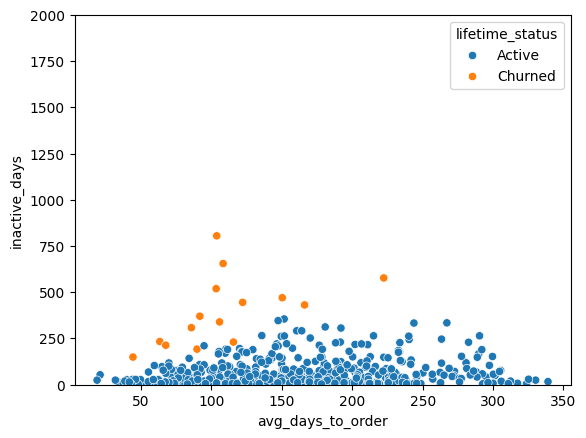

In [39]:
plt.ylim(0, 2000)
sns.scatterplot(repeat_purchasers[repeat_purchasers.n_orders>5], x='avg_days_to_order', y='inactive_days', hue='lifetime_status')

<Axes: xlabel='avg_days_to_order', ylabel='inactive_days'>

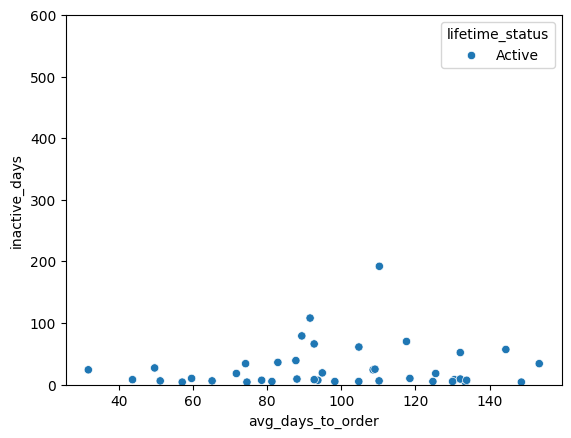

In [40]:
plt.ylim(0, 600)
sns.scatterplot(repeat_purchasers[repeat_purchasers.n_orders>10], x='avg_days_to_order', y='inactive_days', hue='lifetime_status')

<Axes: xlabel='avg_days_to_order', ylabel='std_days_to_order'>

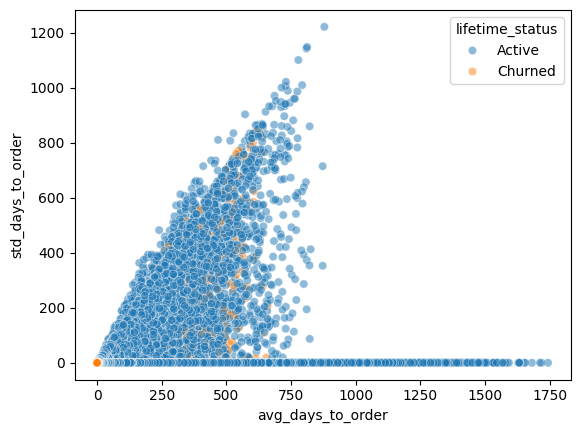

In [41]:
sns.scatterplot(repeat_purchasers, 
                x='avg_days_to_order', y='std_days_to_order', 
                hue='lifetime_status', alpha=0.5)

<Axes: xlabel='active_days', ylabel='n_orders'>

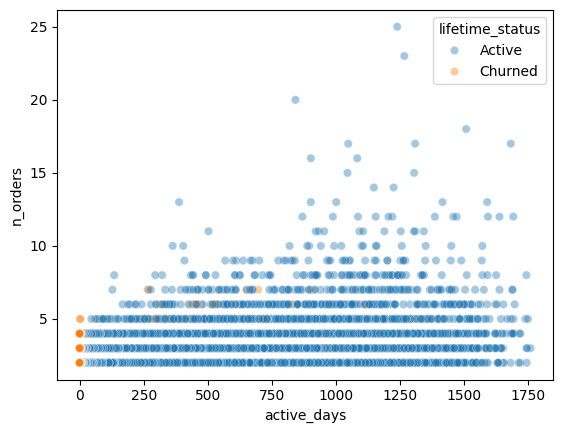

In [42]:
sns.scatterplot(repeat_purchasers, x='active_days', y='n_orders', 
                hue='lifetime_status', alpha=0.4)

<Axes: xlabel='n_orders', ylabel='avg_days_to_order'>

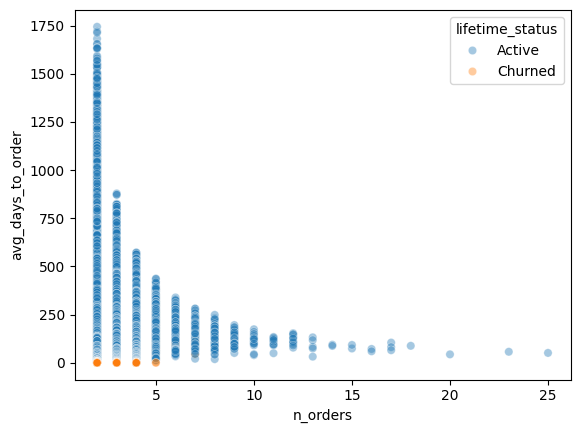

In [43]:
sns.scatterplot(repeat_purchasers, 
                x='n_orders', y='avg_days_to_order', 
                hue='lifetime_status', alpha=0.4)